<a href="https://colab.research.google.com/github/Ziadashraf301/Mental-exploring/blob/main/Depression%20detection/depression_detection_with_bert.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# ============================================================================
# BERT-based Depression Classification System
# ============================================================================

# STEP 1: Install Required Libraries
# ============================================================================
!pip install transformers datasets accelerate -q
!pip install scikit-learn pandas numpy matplotlib seaborn -q

# STEP 2: Import Libraries
# ============================================================================
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.metrics import (accuracy_score, precision_recall_fscore_support,
                             confusion_matrix, classification_report,
                             roc_curve, roc_auc_score)
import torch
from torch.utils.data import Dataset, DataLoader
from transformers import (AutoTokenizer, AutoModelForSequenceClassification,
                         Trainer, TrainingArguments, EarlyStoppingCallback)
from datasets import Dataset as HFDataset
import warnings
warnings.filterwarnings('ignore')

# Check GPU availability
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")
print(f"GPU: {torch.cuda.get_device_name(0) if torch.cuda.is_available() else 'Not available'}")

Using device: cuda
GPU: Tesla T4


In [ ]:
# STEP 3: Load Data
# Upload the CSV file to Colab from Google Drive

from google.colab import drive
drive.mount('/content/drive/')
final_data = pd.read_csv('/content/drive/MyDrive/data_final.csv')

print("Dataset Info:")
print(f"Total samples: {len(final_data)}")
print(f"\nClass distribution:")
print(final_data['is_depression'].value_counts())
print(f"\nClass balance: {final_data['is_depression'].value_counts(normalize=True)}")

Drive already mounted at /content/drive/; to attempt to forcibly remount, call drive.mount("/content/drive/", force_remount=True).
Dataset Info:
Total samples: 329593

Class distribution:
is_depression
0    169174
1    160419
Name: count, dtype: int64

Class balance: is_depression
0    0.513282
1    0.486718
Name: proportion, dtype: float64



Missing values:
filtered_tweet    0
is_depression     0
dtype: int64

Text length statistics:
count    329593.000000
mean        362.313599
std         596.415138
min           1.000000
25%          67.000000
50%         162.000000
75%         426.000000
max       27301.000000
Name: text_length, dtype: float64


Text(0, 0.5, 'Count')

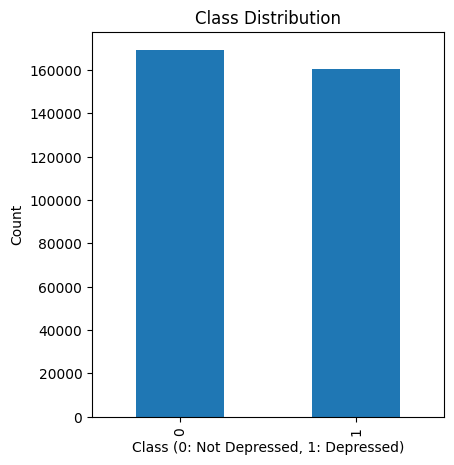

In [ ]:
# STEP 4: Data Exploration & Cleaning
# ============================================================================
# Check for missing values
print("\nMissing values:")
print(final_data.isnull().sum())

# Remove any null values
final_data = final_data.dropna()

# Basic text statistics
final_data['text_length'] = final_data['filtered_tweet'].str.len()
print("\nText length statistics:")
print(final_data['text_length'].describe())

# Visualize class distribution
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
final_data['is_depression'].value_counts().plot(kind='bar')
plt.title('Class Distribution')
plt.xlabel('Class (0: Not Depressed, 1: Depressed)')
plt.ylabel('Count')

<Axes: title={'center': 'text_length'}, xlabel='is_depression'>

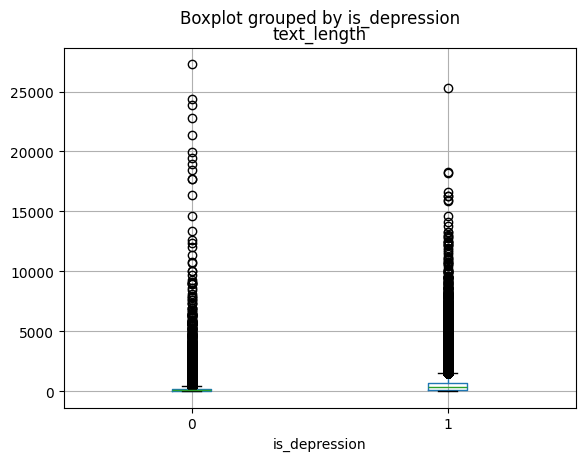

In [ ]:
final_data.boxplot(column='text_length', by='is_depression')

In [ ]:
# STEP 5: Train-Test Split (Stratified)
# ============================================================================
# Use stratified split to maintain class balance
X = final_data['filtered_tweet'].values
y = final_data['is_depression'].values

X_train, X_temp, y_train, y_temp = train_test_split(
    X, y, test_size=0.3, random_state=42, stratify=y
)
X_val, X_test, y_val, y_test = train_test_split(
    X_temp, y_temp, test_size=0.5, random_state=42, stratify=y_temp
)

print(f"\nTrain size: {len(X_train)}")
print(f"Validation size: {len(X_val)}")
print(f"Test size: {len(X_test)}")
print(f"\nTrain class distribution: {np.bincount(y_train)}")
print(f"Val class distribution: {np.bincount(y_val)}")
print(f"Test class distribution: {np.bincount(y_test)}")


Train size: 230715
Validation size: 49439
Test size: 49439

Train class distribution: [118422 112293]
Val class distribution: [25376 24063]
Test class distribution: [25376 24063]


In [ ]:
from google.colab import userdata

#STEP 6: Choose RoBERTa Model (Often better performance)
MODEL_NAME = "roberta-base"

print(f"\nLoading model: {MODEL_NAME}")

import wandb

wandb.login(key=userdata.get('wandb'))
hf_token = userdata.get('huggingface')
!huggingface-cli login --token {hf_token}

# Load tokenizer
tokenizer = AutoTokenizer.from_pretrained(MODEL_NAME)


Loading model: roberta-base


wandb: WARNING If you're specifying your api key in code, ensure this code is not shared publicly.
wandb: WARNING Consider setting the WANDB_API_KEY environment variable, or running `wandb login` from the command line.
wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc
wandb: Currently logged in as: ziadashraf98765 (ziadashraf98765-) to https://api.wandb.ai. Use `wandb login --relogin` to force relogin


⚠️  Warning: 'huggingface-cli login' is deprecated. Use 'hf auth login' instead.
The token has not been saved to the git credentials helper. Pass `add_to_git_credential=True` in this function directly or `--add-to-git-credential` if using via `hf`CLI if you want to set the git credential as well.
Token is valid (permission: fineGrained).
The token `ziad` has been saved to /root/.cache/huggingface/stored_tokens
Your token has been saved to /root/.cache/huggingface/token
Login successful.
The current active token is: `ziad`


In [ ]:
# STEP 7: Create Custom Dataset Class
# ============================================================================
class DepressionDataset(Dataset):
    def __init__(self, texts, labels, tokenizer, max_length=512):
        self.texts = texts
        self.labels = labels
        self.tokenizer = tokenizer
        self.max_length = max_length

    def __len__(self):
        return len(self.texts)

    def __getitem__(self, idx):
        text = str(self.texts[idx])
        label = self.labels[idx]

        # Tokenize
        encoding = self.tokenizer(
            text,
            add_special_tokens=True,
            max_length=self.max_length,
            padding='max_length',
            truncation=True,
            return_attention_mask=True,
            return_tensors='pt'
        )

        return {
            'input_ids': encoding['input_ids'].flatten(),
            'attention_mask': encoding['attention_mask'].flatten(),
            'labels': torch.tensor(label, dtype=torch.long)
        }

In [ ]:
# STEP 8: Prepare Datasets
# ============================================================================
# Determine optimal max_length based on your data

max_length = min(128, int(final_data['text_length'].quantile(0.99)))
print(f"\nUsing max_length: {max_length}")


Using max_length: 128


In [ ]:
# Create datasets
train_dataset = DepressionDataset(X_train, y_train, tokenizer, max_length)
val_dataset = DepressionDataset(X_val, y_val, tokenizer, max_length)
test_dataset = DepressionDataset(X_test, y_test, tokenizer, max_length)

In [ ]:
# STEP 9: Define Evaluation Metrics
# ============================================================================
def compute_metrics(pred):
    labels = pred.label_ids
    preds = pred.predictions.argmax(-1)

    # Calculate metrics
    precision, recall, f1, _ = precision_recall_fscore_support(
        labels, preds, average='binary'
    )
    acc = accuracy_score(labels, preds)

    # AUC-ROC (using probabilities)
    probs = torch.softmax(torch.tensor(pred.predictions), dim=1)[:, 1].numpy()
    auc = roc_auc_score(labels, probs)

    return {
        'accuracy': acc,
        'f1': f1,
        'precision': precision,
        'recall': recall,
        'auc_roc': auc
    }

In [ ]:
# Detailed parameter analysis
def print_model_parameters(model):
    total_params = 0
    trainable_params = 0

    print("\n" + "="*70)
    print("PARAMETER BREAKDOWN")
    print("="*70)

    for name, param in model.named_parameters():
        total_params += param.numel()
        if param.requires_grad:
            trainable_params += param.numel()
            print(f"✓ TRAINABLE: {name:50s} {param.numel():>12,}")
        else:
            print(f"✗ FROZEN:    {name:50s} {param.numel():>12,}")

    print("="*70)
    print(f"Total parameters:     {total_params:>12,}")
    print(f"Trainable parameters: {trainable_params:>12,} ({trainable_params/total_params*100:.2f}%)")
    print(f"Frozen parameters:    {total_params-trainable_params:>12,}")
    print("="*70)

In [ ]:
# STEP 10: Load Pre-trained Model
# ============================================================================
from peft import LoraConfig, get_peft_model
model = AutoModelForSequenceClassification.from_pretrained(
    MODEL_NAME,
    num_labels=2,
    problem_type="single_label_classification"
)

# Configure LoRA
lora_config = LoraConfig(
    r=16,                                    # Rank of adapter
    lora_alpha=32,                           # Scaling factor
    target_modules=["query", "value"],       # Which modules to adapt
    lora_dropout=0.1,                        # Dropout
    bias="none",                             # Don't adapt biases
    task_type="SEQ_CLS"                      # Task type
)

model = get_peft_model(model, lora_config)
model.to(device)
model.print_trainable_parameters()

Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


trainable params: 1,181,954 || all params: 125,829,124 || trainable%: 0.9393


In [ ]:
# STEP 11: Training Configuration
# ============================================================================
# Calculate class weights for imbalanced data
class_counts = np.bincount(y_train)
class_weights = len(y_train) / (len(class_counts) * class_counts)
print(f"\nClass weights: {class_weights}")

training_args = TrainingArguments(
    output_dir='/content/drive/MyDrive/bert_depression_detection/results',
    num_train_epochs=10,
    per_device_train_batch_size=128,
    per_device_eval_batch_size=128,
    warmup_steps=500,
    weight_decay=0.01,
    logging_dir='/content/drive/MyDrive/bert_depression_detection/logs',
    logging_steps=100,
    eval_strategy='steps',
    eval_steps=500,
    save_strategy='steps',
    save_steps=500,
    load_best_model_at_end=True,
    metric_for_best_model='f1',
    greater_is_better=True,
    save_total_limit=2,
    fp16=torch.cuda.is_available(),
    report_to='wandb',
    seed=42
)


Class weights: [0.97412221 1.02729021]


In [ ]:
# STEP 12: Initialize Trainer
# ============================================================================
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=val_dataset,
    compute_metrics=compute_metrics,
    callbacks=[EarlyStoppingCallback(early_stopping_patience=3)]
)

In [ ]:
# STEP 13: Train the Model
# ============================================================================
print("\n" + "="*50)
print("Starting Training...")
print("="*50)

train_result = trainer.train()

print("\n" + "="*50)
print("Training Complete!")
print("="*50)
print(f"Training time: {train_result.metrics['train_runtime']:.2f} seconds")
print(f"Training loss: {train_result.metrics['train_loss']:.4f}")


Starting Training...


Step,Training Loss,Validation Loss,Accuracy,F1,Precision,Recall,Auc Roc
500,0.335000,0.314763,0.876555,0.868529,0.901646,0.837759,0.938388
1000,0.294800,0.282862,0.890329,0.886422,0.893685,0.879275,0.951923
1500,0.264600,0.251187,0.900807,0.895142,0.921911,0.869883,0.959317
2000,0.249600,0.247089,0.903538,0.897333,0.930900,0.866101,0.961404
2500,0.246500,0.241706,0.904691,0.900557,0.914884,0.886672,0.962639
3000,0.247000,0.237963,0.904731,0.900704,0.914039,0.887753,0.963902
3500,0.244300,0.235627,0.907927,0.902061,0.935222,0.871172,0.964894
4000,0.241100,0.234183,0.906309,0.900818,0.929149,0.874164,0.964761
4500,0.238000,0.231562,0.908797,0.904054,0.926347,0.882808,0.966055
5000,0.236600,0.227857,0.909181,0.904711,0.924448,0.885800,0.966617



Training Complete!
Training time: 7238.54 seconds
Training loss: 0.2528


In [ ]:
# STEP 14: Evaluate on Test Set
# ============================================================================
print("\n" + "="*50)
print("Evaluating on Test Set...")
print("="*50)

test_results = trainer.evaluate(test_dataset)
print("\nTest Results:")
for key, value in test_results.items():
    print(f"{key}: {value:.4f}")


Evaluating on Test Set...



Test Results:
eval_loss: 0.2253
eval_accuracy: 0.9103
eval_f1: 0.9070
eval_precision: 0.9149
eval_recall: 0.8993
eval_auc_roc: 0.9685
eval_runtime: 107.7573
eval_samples_per_second: 458.7990
eval_steps_per_second: 3.5910
epoch: 4.9917


In [ ]:
# STEP 15: Generate Predictions
# ============================================================================
predictions = trainer.predict(test_dataset)
pred_labels = predictions.predictions.argmax(-1)
pred_probs = torch.softmax(torch.tensor(predictions.predictions), dim=1)[:, 1].numpy()


Classification Report:
               precision    recall  f1-score   support

Not Depressed       0.91      0.92      0.91     25376
    Depressed       0.91      0.90      0.91     24063

     accuracy                           0.91     49439
    macro avg       0.91      0.91      0.91     49439
 weighted avg       0.91      0.91      0.91     49439



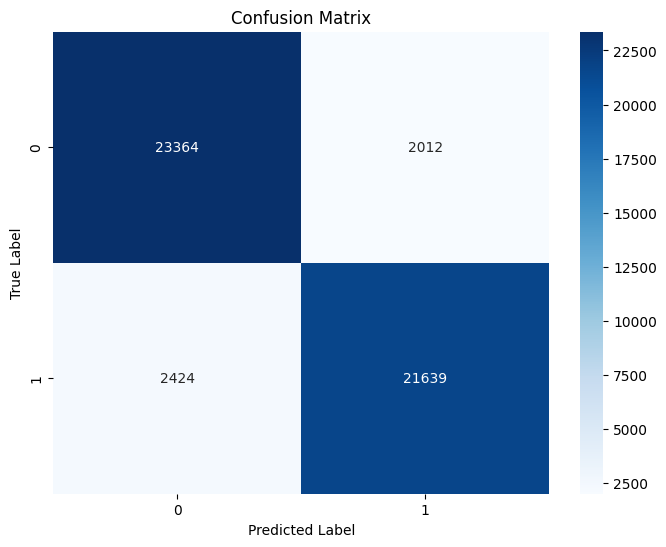

In [ ]:
# STEP 16: Detailed Evaluation
# ============================================================================
# Classification Report
print("\n" + "="*50)
print("Classification Report:")
print("="*50)
print(classification_report(y_test, pred_labels,
                           target_names=['Not Depressed', 'Depressed']))

# Confusion Matrix
cm = confusion_matrix(y_test, pred_labels)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.title('Confusion Matrix')
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.show()


Sensitivity (Recall): 0.8993
Specificity: 0.9207


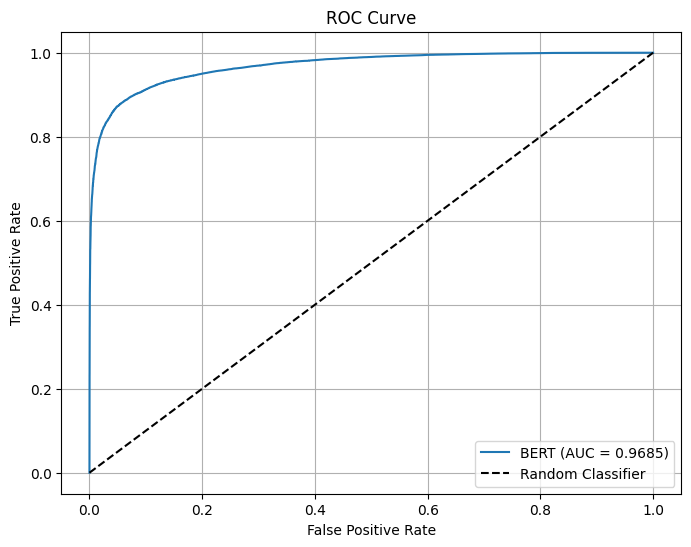


AUC-ROC Score: 0.9685


In [ ]:
# Calculate sensitivity and specificity
tn, fp, fn, tp = cm.ravel()
sensitivity = tp / (tp + fn)
specificity = tn / (tn + fp)
print(f"\nSensitivity (Recall): {sensitivity:.4f}")
print(f"Specificity: {specificity:.4f}")

# ROC Curve
fpr, tpr, thresholds = roc_curve(y_test, pred_probs)
auc = roc_auc_score(y_test, pred_probs)

plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, label=f'BERT (AUC = {auc:.4f})')
plt.plot([0, 1], [0, 1], 'k--', label='Random Classifier')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend()
plt.grid(True)
plt.show()

print(f"\nAUC-ROC Score: {auc:.4f}")

In [ ]:
# STEP 17: Save Model
# ============================================================================

model_save_path = '/content/drive/MyDrive/bert_depression_detection/depression_bert_merged_model'
model.save_pretrained(f'{model_save_path}/lora_adapters')  # Adapters

# Merge LoRA weights into base model
merged_model = model.merge_and_unload()

# Save full model
merged_model.save_pretrained(model_save_path)
tokenizer.save_pretrained(model_save_path)

print(f"\nModel saved to: {model_save_path}")


Model saved to: /content/drive/MyDrive/bert_depression_detection/depression_bert_merged_model


In [ ]:
# STEP 18: Inference Function
# ============================================================================
def predict_depression(text, model, tokenizer, device, max_length=128):
    """
    Predict depression from a single text input

    Args:
        text: Input text string
        model: Trained BERT model
        tokenizer: BERT tokenizer
        device: torch device (cuda/cpu)
        max_length: Maximum sequence length

    Returns:
        dict: Prediction results
    """
    model.eval()

    # Tokenize
    encoding = tokenizer(
        text,
        add_special_tokens=True,
        max_length=max_length,
        padding='max_length',
        truncation=True,
        return_attention_mask=True,
        return_tensors='pt'
    )

    # Move to device
    input_ids = encoding['input_ids'].to(device)
    attention_mask = encoding['attention_mask'].to(device)

    # Predict
    with torch.no_grad():
        outputs = model(input_ids=input_ids, attention_mask=attention_mask)
        logits = outputs.logits
        probs = torch.softmax(logits, dim=1)
        pred_class = torch.argmax(probs, dim=1).item()
        confidence = probs[0][pred_class].item()

    return {
        'prediction': 'Depressed' if pred_class == 1 else 'Not Depressed',
        'confidence': confidence,
        'depression_probability': probs[0][1].item(),
        'not_depression_probability': probs[0][0].item()
    }

In [ ]:
# STEP 19: Test Inference
# ============================================================================
print("\n" + "="*50)
print("Testing Inference Function:")
print("="*50)

# Test examples
test_texts = [
    "I feel so hopeless and empty inside",
    "Having a great day with friends!",
    "Everything feels overwhelming and I can't cope anymore",
    """I find myself drifting through the same corridors of thought, the fluorescent lights flickering overhead as though echoing the uncertainty in my heart. It’s as if every step I take is on a glass bridge, fragile and cracked, and I’m constantly wondering if it will shatter under my weight. I remember when I used to wake up with a kind of hope—light streaming through the blinds, the world full of possibility. Now, I wake to a silence so loud it presses against my chest, and I chart the hours by how many breaths I can take without thinking of nothing.

The days have blurred into one another. I watch myself perform routine tasks—make coffee, answer a message, catch a glimpse of myself in the mirror—and realize that the version of me doing them is hollow. I’m here, but I am not present; I’m functioning, but I am not living. The conversations around me happen like background noise. I hear words, but I don’t feel their meaning. I nod and smile because it’s what’s expected, but inside there’s a lethargy so deep that even laughter feels manufactured.

I’ve lost interest in the things that used to ignite me—the rush of creation, the exhilaration of new ideas, the warmth of friendships where time expanded rather than contracted. Now, I find myself reaching for distractions: a scroll, a screen, a book I will never finish. Sometimes I feel dumb for it, like I’m wasting what little life I think I have left. And then guilt arrives, doubling the weight of the emptiness.

Nights are the worst. During the day there’s the pretense. At night, the pretense drops away and I’m left with the slow drip of sadness, like water that seeps through a cracked foundation, unnoticed until the damage is done. My mind becomes a looping soundtrack of “what ifs” and “should haves” and a crawling sense of failure: that I should be more, do more, feel more. But I don’t. I just am. And that “just” feels like a sentence.

I’m aware of the paradox: I don’t want to feel this way, yet I feel it continuously. I don’t want to stay still, yet my feet won’t move. I don’t want to be alone, yet even when I’m surrounded the loneliness envelops me as though I’m invisible. I keep thinking maybe this is a phase, maybe I’ll wake up differently tomorrow, but “tomorrow” has lost its meaning—it just means another set of hours to survive.

The hardest part is believing that the gloom will ever lift. Hope seems like a word used by other people—by people whose hearts aren’t weighed down by the shadow I carry. Sometimes a small flicker of memory rises: the taste of summer wind, the bark of a dog in the distance, the wildness of an idea that once lit me up. And in that moment I think: maybe there’s a door somewhere, maybe I’ll find the key. But the key is heavy, and the door so far away.

And so I wait in this limbo, between what I used to be and what I fear I will become. Between the echo of my dreams and the dull thud of reality. I try to whisper to myself: keep going. But the whisper fades, and the silence settles in again. """
, """Some mornings feel ordinary—the sunlight filters through the blinds, the smell of coffee fills the room, and for a brief moment everything seems perfectly normal. I check my phone, scroll through messages, maybe reply to a friend about weekend plans. There’s comfort in the routine, even if it feels mechanical sometimes. Life moves in small motions—commuting, talking, working, eating—and yet I often wonder what lies beneath all these repeated gestures.

I think about how strange it is that emotions can coexist so easily: calm and restlessness, satisfaction and longing, all sitting quietly next to each other. One part of me enjoys the familiarity of daily life; another part feels like I’m standing outside of it, observing from a distance. Still, there are moments that break through—the taste of a favorite meal, the warmth of laughter shared unexpectedly, the sudden spark of a new idea that reminds me I’m still alive and curious.

Sometimes I feel deeply connected to everything: the sound of rain against the window, the faint hum of the city, even the weight of my own thoughts. Other times, I feel like I’m drifting—my mind wandering into what-ifs and half-finished dreams. But that’s just how life seems to work: a mix of meaning and uncertainty, order and chaos.

I try to stay grounded by focusing on small things—watering a plant, organizing my desk, calling someone I care about. These acts don’t fix everything, but they anchor me. I’ve realized that not every day has to be extraordinary; some days are simply meant to be lived quietly.

There’s something honest about ordinary days—the way they pass without drama, the way the world continues to turn regardless of what I’m feeling. And in that quiet rhythm, I find traces of peace. Maybe that’s what growing up really is: learning to find balance between movement and stillness, excitement and calm.

I still have dreams, of course. There are things I want to build, places I want to see, people I hope to meet. And though the path ahead isn’t perfectly clear, I’ve started to understand that uncertainty doesn’t always mean danger—it can also mean possibility. Life, in all its noise and silence, keeps offering chances to begin again."""]

for text in test_texts:
    result = predict_depression(text, model, tokenizer, device)
    print(f"\nText: '{text}'")
    print(f"Prediction: {result['prediction']}")
    print(f"Confidence: {result['confidence']:.4f}")
    print(f"Depression Prob: {result['depression_probability']:.4f}")

# STEP 20: Feature Analysis (Optional)
# ============================================================================
print("\n" + "="*50)
print("Model Summary:")
print("="*50)
print(f"Final Test Accuracy: {test_results['eval_accuracy']:.4f}")
print(f"Final Test F1-Score: {test_results['eval_f1']:.4f}")
print(f"Final Test AUC-ROC: {test_results['eval_auc_roc']:.4f}")
print(f"Final Test Precision: {test_results['eval_precision']:.4f}")
print(f"Final Test Recall: {test_results['eval_recall']:.4f}")

print("\n" + "="*50)
print("Training Complete! Model ready for deployment.")
print("="*50)



Testing Inference Function:

Text: 'I feel so hopeless and empty inside'
Prediction: Depressed
Confidence: 0.9459
Depression Prob: 0.9459

Text: 'Having a great day with friends!'
Prediction: Not Depressed
Confidence: 0.8550
Depression Prob: 0.1450

Text: 'Everything feels overwhelming and I can't cope anymore'
Prediction: Depressed
Confidence: 0.9544
Depression Prob: 0.9544

Text: 'I find myself drifting through the same corridors of thought, the fluorescent lights flickering overhead as though echoing the uncertainty in my heart. It’s as if every step I take is on a glass bridge, fragile and cracked, and I’m constantly wondering if it will shatter under my weight. I remember when I used to wake up with a kind of hope—light streaming through the blinds, the world full of possibility. Now, I wake to a silence so loud it presses against my chest, and I chart the hours by how many breaths I can take without thinking of nothing.

The days have blurred into one another. I watch myself per